In [1]:
# Notebook to generate data and append it in df
# We use the following format: 
# Edge betweenness, length, max of degree of connecting nodes, sum of degrees of connecting nodes, stress of the edge
# euclidean distance between gradient of KK before and after taking the edge out, Expansion factor, crossings minimized
# difference in average edge length, number of nodes, number of edges

# The last two are kept for normalization purposes.

import pandas as pd
import glob
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from src.graph_dataset import GraphDataset
from src.graph_parser import parseGraphmlFile
from src.graph_utils import stress, total_stress, num_crossings, mean_edge_length, nodes_dict_to_array
from src.graph_utils import  gradient_kamada_kawai, max_neighbour_degrees_norm, sum_neighbour_degrees_norm, expansion_factor_norm, edge_crossings_norm

In [2]:
def read_list_of_graphs(dir_name,ext):
    list_graphs = [parseGraphmlFile(dir_name+f,weighted=False,directed=False) for f in os.listdir(dir_name) if f.endswith('.' + ext)]
    return list_graphs

# Generate Dataframe

In [3]:
n = 100
draw_f = lambda g: nx.kamada_kawai_layout(g, pos=nx.spectral_layout(g))
benchmarks = ['random-dag', 'rome', 'north']

data = []
for bench in benchmarks:
    list_graphs = read_list_of_graphs(f'../data/{bench}/','graphml')
    for idx_graph, graph in tqdm(list(enumerate(list_graphs[:n]))):

        # Run Spectral +  Kamada-Kawai
        pos0 = draw_f(graph)

        # Compute general graph attributes
        eb = nx.edge_betweenness(graph)     # edge betweenness
        st = stress(graph, pos0)             # stress
        cross0 = num_crossings(graph, pos0) 
        edgel0 = mean_edge_length(graph, pos0)
        total_stress0 = total_stress(graph, pos0)
        deg = nx.degree(graph, graph.nodes)
        bridges = nx.bridges(graph)

        for idx_edge, e in enumerate(graph.edges):
            n1, n2 = e
            
            # New position removing edge
            graph_copy = graph.copy()
            graph_copy.remove_edges_from([e])
            pos1 = nx.kamada_kawai_layout(graph_copy,pos=pos0)
            pos1_arr = nodes_dict_to_array(pos1)
            pos0_arr = nodes_dict_to_array(pos0)
            cross1 = num_crossings(graph, pos1) 
            edgel1 = mean_edge_length(graph, pos1)
            total_stress1 = total_stress(graph, pos1)
            deg = nx.degree(graph, graph.nodes)
            exp_factor_norm = expansion_factor_norm(pos0_arr,pos1_arr)
            edge_cross_norm = edge_crossings_norm(cross0-cross1, len(graph_copy.edges))

            # Extra attributes
            max_deg = max(deg[n1], deg[n2])
            min_deg = min(deg[n1], deg[n2])
            sum_neighbour_deg_norm = sum_neighbour_degrees_norm(graph_copy,e)
            max_neighbour_deg_norm = max_neighbour_degrees_norm(graph_copy,e)
            nnodes, nedges = len(graph.nodes), len(graph.edges)
            row = [idx_graph, idx_edge, nnodes, nedges, eb[e], st[e], max_deg, min_deg, e in bridges,
                total_stress0 - total_stress1, cross0 - cross1, edgel0 - edgel1,
                bench, exp_factor_norm, edge_cross_norm, sum_neighbour_deg_norm, max_neighbour_deg_norm]
            data.append(row)

    cols = ['graph_id', 'edge_id', 'num_nodes', 'num_edges', 'edge_betweenness', 'stress', 'max_deg', 'min_deg', 'is_bridge', 'diff_stress', 'diff_cross', 'diff_edgelength', 'benchmark', 'exp_factor_norm', 'edge_cross_norm', 'sum_neighbour_deg_norm', 'max_neighbour_deg_norm']
    df = pd.DataFrame(data, columns=cols)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [4]:
df.head()

,graph_id,edge_id,num_nodes,num_edges,edge_betweenness,stress,max_deg,min_deg,is_bridge,diff_stress,diff_cross,diff_edgelength,benchmark
0,0,0,13,22,0.057692,0.391451,6,4,False,1.500317,4,-0.038062,random-dag
1,0,1,13,22,0.012821,0.653058,4,4,False,-0.154834,0,0.004703,random-dag
2,0,2,13,22,0.044872,0.672180,6,4,False,0.212624,4,-0.005237,random-dag
3,0,3,13,22,0.038462,0.447425,5,4,False,0.537798,4,-0.026485,random-dag
4,0,4,13,22,0.102564,0.617102,6,6,False,-0.747067,8,-0.000675,random-dag


In [5]:
df.to_csv('../data/graph_train.csv')

# Some stats

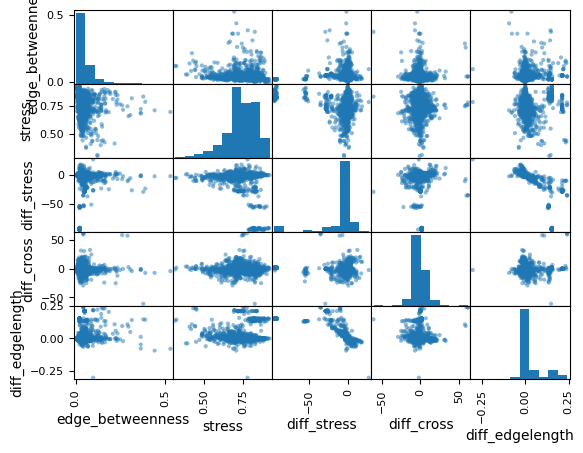

In [6]:
pd.plotting.scatter_matrix(df[['edge_betweenness', 'stress', 'diff_stress', 'diff_cross', 'diff_edgelength']]);

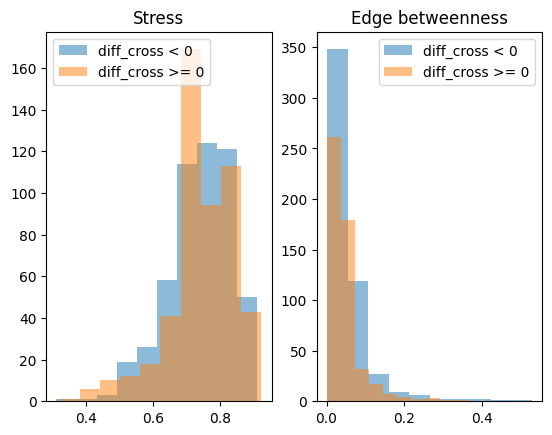

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)

x = df[df['diff_cross'] < 0].stress
y = df[df['diff_cross'] >= 0].stress
ax1.hist(x, bins=10, alpha=0.5, label='diff_cross < 0')
ax1.hist(y, bins=10, alpha=0.5, label='diff_cross >= 0')
ax1.legend(loc='upper left')
ax1.set_title('Stress')

x = df[df['diff_cross'] < 0].edge_betweenness
y = df[df['diff_cross'] >= 0].edge_betweenness
ax2.hist(x, bins=10, alpha=0.5, label='diff_cross < 0')
ax2.hist(y, bins=10, alpha=0.5, label='diff_cross >= 0')
ax2.legend(loc='upper right')
ax2.set_title('Edge betweenness')

plt.show()

# Read Generated Dataframe

In [8]:
df = pd.read_csv('../data/graph_train.csv')